### SEGAN without the GAN

Original SEGAN paper: https://arxiv.org/pdf/1703.09452.pdf

In [26]:
import os
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchaudio import transforms
from data import CleanSpeechDataset
import time
from model import Autoencoder
import pdb
import matplotlib.pyplot as plt
from pypesq import pesq
import torch.nn.functional as F
import torchaudio
from tqdm.notebook import trange, tqdm
from IPython.display import Audio

In [8]:
num_epochs = 10
batch_size = 512
learning_rate = 3e-5

In [9]:
MODEL_PATH = 'models/seae.pth'

If you'd like to run the training loop, download the OpenSLR12 dataset (http://www.openslr.org/12/), convert all .flac files to .wav and copy to 'data/clean/open_slr'

In [10]:
dataset = CleanSpeechDataset('data/clean/360/', window_size=16384, overlap=50)

In [11]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [12]:
model = Autoencoder().cuda()
model.load_state_dict(torch.load(MODEL_PATH))
criterion = nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-5)

model.train()

# data = next(iter(dataloader))
for epoch in trange(num_epochs):
    print(f'Starting epoch {epoch + 1}')
    
    pbar = tqdm()
    pbar.reset(total=(len(dataset) // batch_size))
    
    for i, data in enumerate(dataloader):
        sample = data
        sample = Variable(sample).cuda()
        output = model(sample)
        loss = criterion(output, sample)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.update()
    
    pbar.refresh()
    
    torch.save(model.state_dict(), f'models/seae_epoch_{epoch}.pth')
    
    if True or epoch % 5 == 0:
        print(f'epoch [{epoch}/{num_epochs}]')
        print(round(loss.item(), 5))

Starting epoch 1


Epoch took 9751.0975s
Expected hours to train: 27.09
epoch [0/10]
0.00038
Starting epoch 2


epoch [1/10]
0.00037
Starting epoch 3


epoch [2/10]
0.00037
Starting epoch 4


KeyboardInterrupt: 

In [ ]:
model

In [27]:
pesqs = []

model.eval()
with torch.no_grad():
    sample = data.cuda()
    for i, _s in enumerate(sample[:2]):
        output = model(sample)
        ref = output[i, :, :].cpu().detach().numpy().T
        target = sample[i, :, :].cpu().detach().numpy().T
        # plt.figure()
        # plt.plot(ref)
        # plt.figure()
        # plt.plot(target)

        pesqs.append(pesq(ref[:, 0], target[:, 0], 16000))
print(sum(pesqs) / len(pesqs))
Audio(ref[:, 0], rate=16000)

3.3516794443130493


In [13]:
torch.save(model.state_dict(), 'models/seae_epoch_3.pth')

Shape of spectrogram: torch.Size([1, 513, 2461])


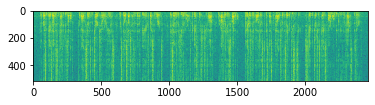

In [14]:
f = 'data/clean/open_slr/2902-9006-0001.wav'
wave, _ = torchaudio.load(f)
specgram = torchaudio.transforms.Spectrogram(1024, 300)(wave)

print("Shape of spectrogram: {}".format(specgram.size()))

plt.figure()
plt.imshow(specgram.log2()[0,:,:].numpy())